In [1]:
import os
import os.path as path
import re
from enum import Enum

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
# tqdm.pandas(desc='Processing Dataframe', leave=False, position=1)
import tafra
import ptitprince as pt

mpl.style.use('seaborn')
# %matplotlib notebook
# xkcd-colors: https://matplotlib.org/stable/_images/sphx_glr_colors_003.png

## Hallway Parameters and Definitions

In [2]:
class Boxes(Enum):
    NoBox = 0
    SmallL = 10
    SmallC = 11
    SmallR = 12
    LargLC = 20
    LargCR = 21
    LargLR = 22
    
# w x d x h
smBox = [.6, .3, .9]
lgBox = [.95, .3, 1.8]
pRadius = .225
hwWidth = 2.85
segmentLength = 2
hwStartX = [0, 4, 8]

hallway1 = [
            Boxes.SmallC,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.LargLC, # transition to 5
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallC
]

hallway2 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR, # transition to 3
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallway3 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLC, # transition to 7
            Boxes.SmallR,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallways = [hallway1, hallway2, hallway3]

## Map Drawing Functions

In [3]:
def map_hallways():
    length = (4 + len(hallway1)) * segmentLength
    fig, axs = plt.subplots(3,1,figsize=(length, hwWidth*3.3))
    for idx,(ax, hallway) in enumerate(zip(axs, (hallway1, hallway2, hallway3))):
        create_map(hallway, ax)
        ax.text(-segmentLength, hwWidth/2, 
                f"HW-{idx}", fontsize=56, 
                va='center', ha='left')
        
    return fig, axs

def create_map(hallway, ax):
    # total length is 3 empty rooms + no. of obstacles
    length = (3 + len(hallway)) * segmentLength
    
    ax.set_axis_off()
    ax.set_xlim((0, length))
    ax.set_ylim((0, hwWidth))
    # background
    rect = Rectangle((0, 0), length, hwWidth, 
                     edgecolor='none', facecolor='xkcd:ivory', zorder=0)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # the hallway obstacles
    # since first 2 rooms are empty, the actual first room starts at segmentLength*2
    # obstacles are placed at the end of a segment so the box starts at
    # segmentLength - boxDepth in relation to the room start
    boxPatches = []
    roomEnd = 3 * segmentLength
    for box in hallway:
        if box == Boxes.SmallL:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, hwWidth-dY)
        elif box == Boxes.SmallC:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, (hwWidth-dY) / 2)
        elif box == Boxes.SmallR:
            dY,dX,_ = smBox
            anchor = (roomEnd - dX, 0)
        elif box == Boxes.LargLC:
            dY,dX,_ = lgBox
            dY *= 2 # *2 because it's 2 boxes next to each other
            anchor = (roomEnd - dX, hwWidth-dY) 
        elif box == Boxes.LargCR:
            dY,dX,_ = lgBox
            dY *= 2 # *2 because it's 2 boxes next to each other
            anchor = (roomEnd - dX, 0)
        elif box == Boxes.LargLR:
            dY,dX,_ = lgBox
            anchor = (roomEnd - dX, hwWidth - dY)
            boxPatches.append(box_patch(anchor, dX, dY))
            anchor = (roomEnd - dX, 0)
            boxPatches.append(box_patch(anchor, dX, dY))
            
            roomEnd += segmentLength
            continue
        
        boxPatches.append(box_patch(anchor, dX, dY))
        roomEnd += segmentLength
    
    pc = PatchCollection(boxPatches, edgecolor='none',
                 facecolor='xkcd:chocolate', zorder=10)
    ax.add_collection(pc)
    
    roomEnd = segmentLength
    dividers = []
    while roomEnd < length:
        dividers.append(Rectangle((roomEnd, 0), .1*segmentLength, hwWidth))
        roomEnd += segmentLength
    
    pc = PatchCollection(dividers, edgecolor='none', 
                         facecolor= 'xkcd:grey', alpha=.6, zorder=5)
    ax.add_collection(pc)
                        
def box_patch(anchor, dX, dY):
    return Rectangle(anchor, dX, dY)

In [4]:
subjPattern = re.compile(r"^\d+$")
trialPattern = re.compile(r"(?P<block>\d\d)_(?P<trial>\d\d)(?P<data>\w+)\.tsv")

ID01 = "00"
ID02 = "01"
ID03 = "02"
IDENTS = [ID01, ID02, ID03]

In [5]:
subjects = [d for d in os.listdir() if subjPattern.match(d)][:-1]
print(subjects)

colors = mcolors.XKCD_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
as_hex = [(mcolors.to_hex(c), n) for c,n in by_hsv]

step = (len(as_hex)-3) // len(subjects)
subj_colors = as_hex[3::step]

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020']


In [6]:
def load_subject(subjId):
    datadict = {
        ID01 : {ID01 : [], ID02 : [], ID03 : []}, # block 1
        ID02 : {ID01 : [], ID02 : [], ID03 : []}, # block 2
        ID03 : {ID01 : [], ID02 : [], ID03 : []} # block 3
    }
    files = os.listdir(subjId)
    for file in files:
        match = trialPattern.match(file)
        if not match:
            print("Error!", file)
            continue
        block_id = match.groups()[0]
        trial_id = match.groups()[1]
        datadict[block_id][trial_id].append(file)
        
    return datadict

In [7]:
def vec2coord(s:pd.Series, keep=[0,1,2]):
    """Convert the stored vector in str: '(x,y,z)' to df with columns x&y"""
    vecs = s.apply(lambda v: np.array(v[1:-1].split(', ')).astype(float))
    p = pd.DataFrame(np.stack(vecs.values))
    p = p[p.columns[keep]]
    labels = np.array(['x', 'y', 'z'])
    p.columns = labels[:len(keep)]
    p.index = s.index
    return p

def pos2path(s:pd.Series, hallwayId:int):
    # convert text vector to 2d vector array
    # [2,0] "rotates" vector, hallways are drawn left -> right
    # so x (left, right) becomes y, and z (forward) becomes x
    p = vec2coord(s, [2,0])
    # 0-center path by subtracting hallway offset (id * 4)
    # in Unity right is positive, left is negative
    # we must negate to get correct orientation
    # then add half-width to put correct starting position
    p.y = -1 * (p.y - hallwayId * 4) + hwWidth / 2
    # add segment-length to account for first empty room behind start
    p.x += segmentLength
    return p

def round_to_multiple(number, multiple):
    return multiple * round(number / multiple)

def draw_path(s:pd.Series, axs:plt.Axes, hwId:int, color):
    # startoffset is rounded down start position
    # offset is 0, 4 or 8
    # center start in hallway
    if not ('x' in s.columns and 'y' in s.columns):
        p = pos2path(s, hwId)
    else:
        p = s
    return axs[hwId].scatter(p.x, p.y, 24, alpha=.33, c=color), axs[hwId].plot(p.x, p.y, '--', alpha=.4, color='grey')

def draw_all_paths(subjId:str, colors = ['xkcd:maroon', 'xkcd:lightblue', 'xkcd:green']):
    datadict = load_subject(subjId)
    fig, axs = map_hallways()
    fig.suptitle(subjId, fontsize=32)

    for idx, blockId in enumerate(IDENTS):
        for trialId in IDENTS:
            trial = datadict[blockId][trialId]

            # -1 --> trial config
            filepath = path.join(subjId, trial[-1])
            df = pd.read_csv(filepath, sep='\t')
            hwId = int(df.Hallway[0][-1]) - 1

            # 0 --> engine data
            filepath = path.join(subjId, trial[0])
            df = pd.read_csv(filepath, sep='\t')
            s = df.XRHeadPos

            draw_path(s, axs, hwId, colors[idx])

018\00_00EngineDataRecord.tsv
018\00_01EngineDataRecord.tsv
018\00_02EngineDataRecord.tsv
018\01_00EngineDataRecord.tsv
018\01_01EngineDataRecord.tsv
018\01_02EngineDataRecord.tsv
018\02_00EngineDataRecord.tsv
018\02_01EngineDataRecord.tsv
018\02_02EngineDataRecord.tsv


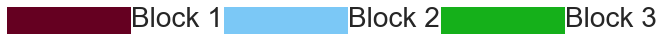

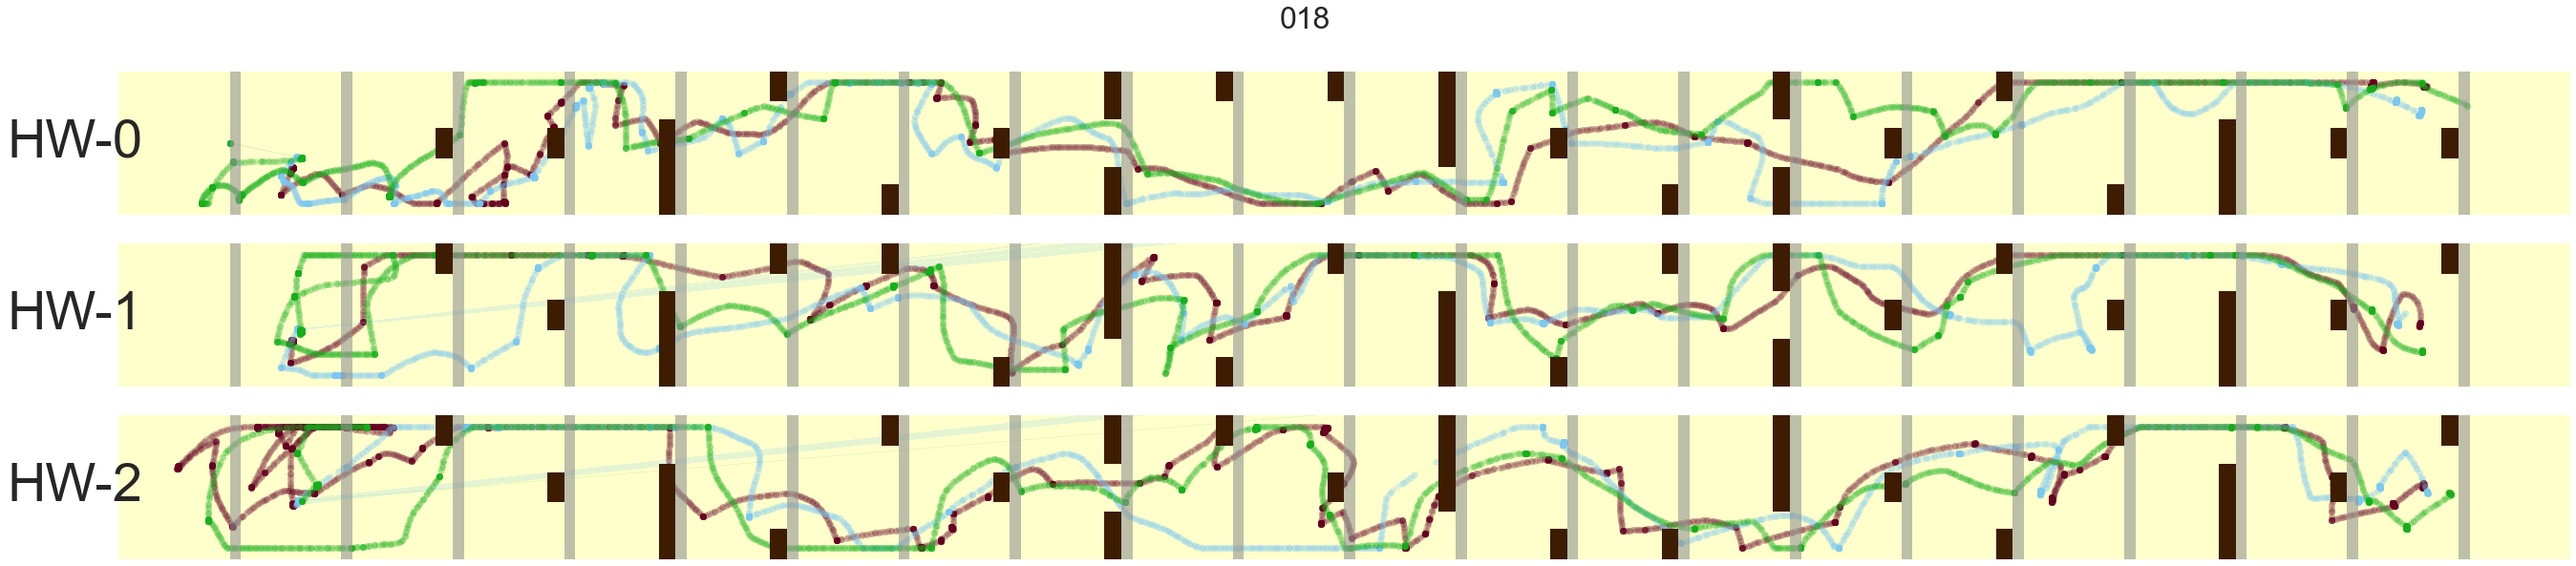

In [16]:
fig, ax = plt.subplots(figsize=(10,.5))
ax.set_axis_off()
ax.add_patch(Rectangle((0,.33), 2, .33, edgecolor='none', facecolor='xkcd:maroon'))
ax.text(2,.5,'Block 1',va='center', ha='left', fontsize=28)
ax.add_patch(Rectangle((3.5,.33), 2, .33, edgecolor='none', facecolor='xkcd:lightblue'))
ax.text(5.5,.5,'Block 2',va='center', ha='left', fontsize=28)
ax.add_patch(Rectangle((7,.33), 2, .33, edgecolor='none', facecolor='xkcd:green'))
ax.text(9,.5,'Block 3',va='center', ha='left', fontsize=28)
ax.set_xlim((0,9))
ax.set_ylim((0.33,.66))
                       

# draw_all_paths('001')
# draw_all_paths('004')
draw_all_paths('018')

In [8]:
def plot_eye_movement(normalise_in_self=False):
    fig, axs = plt.subplots(3,3, figsize=(24,12), dpi=100)
    fig.suptitle("Eye Movement")

    axs[0,0].set_title('Gaze Ignored', fontsize=12)
    axs[0,1].set_title('Gaze Locked', fontsize=12)
    axs[0,2].set_title('Gaze Assisted', fontsize=12)
    axs[0,0].text(-.2, .5, 'Block-1', rotation=90, va='center', ha='right', fontsize=12)
    axs[1,0].text(-.2, .5, 'Block-2', rotation=90, va='center', ha='right', fontsize=12)
    axs[2,0].text(-.2, .5, 'Block-3', rotation=90, va='center', ha='right', fontsize=12)

    for idx in range(len(subjects)):
        subjId = subjects[idx]
        datadict = load_subject(subjId)
        c = subj_colors[idx][1]
        
        to_plot = []
        lMin = np.array([float("inf"), float("inf")])
        lMax = np.array([0, 0])
        rMin = np.array([float("inf"), float("inf")])
        rMax = np.array([0, 0])
        for blockId, block in enumerate(datadict.values()):
            for trialId, trialData in enumerate(block.values()):
                try:
                    fConfig = trialData[-1]
                    fEyeL = trialData[3]
                    fEyeR = trialData[4]
                    dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
                    dfL = pd.read_csv(path.join(subjId, fEyeL), sep='\t')
                    dfR = pd.read_csv(path.join(subjId, fEyeR), sep='\t')
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print(f"Could not load subject: {subjId}")
                    print(e)
                except IndexError as e:
                    print(f"IndexError! For trial {trialId} \w data {trialData} in block {blockId}")
                    print(e)


                condition = dfCfg.GazeCondition[0]

                eyePosL = vec2coord(dfL.PosInSensor, [0,1])
                eyePosL = eyePosL[(eyePosL.x <= 1) & (eyePosL.x >= 0)]
                eyePosL = eyePosL[(eyePosL.y <= 1) & (eyePosL.y >= 0)]
                eyePosR = vec2coord(dfR.PosInSensor, [0,1])
                eyePosR = eyePosR[(eyePosR.x <= 1) & (eyePosR.x >= 0)]
                eyePosR = eyePosR[(eyePosR.y <= 1) & (eyePosR.y >= 0)]

                if normalise_in_self:
                    val = eyePosL.min().values
                    sq = (val * val).sum()
                    if (lMin * lMin).sum() > sq:
                        lMin = val
                    val = eyePosL.max().values
                    sq = (val * val).sum()
                    if (lMax * lMax).sum() < sq:
                        lMax = val
                    val = eyePosR.min().values
                    sq = (val * val).sum()
                    if (rMin * rMin).sum() > sq:
                        rMin = val
                    val = eyePosR.max().values
                    sq = (val * val).sum()
                    if (rMax * rMax).sum() < sq:
                        rMax = val
                
                if 'ignored' in condition.lower():
                    col = 0
                elif 'fixed' in condition.lower():
                    col = 1
                elif 'assist' in condition.lower():
                    col = 2

                to_plot.append(( axs[blockId, col], (eyePosL, eyePosR) ))
                    
                # axs[blockId,col].plot(eyePosL.x, eyePosL.y, 'o--',
                #                       lw=.3, markersize=2, 
                #                       color=c, alpha=.1)
                # axs[blockId,col].plot(eyePosR.x+1.1, eyePosR.y, 'o--',
                #                       lw=.3, markersize=2,
                #                       color=c, alpha=.1)

                if idx == 0:
                    axs[blockId,col].text(0.9, .9, 'L', va='bottom', ha='center', fontsize=10)
                    axs[blockId,col].text(2, .9, 'R', va='bottom', ha='center', fontsize=10)
                    axs[blockId,col].set_xlim((0,2.1))
                    axs[blockId,col].set_ylim((0,1))
                    axs[blockId,col].set_xticks([0, .5, 1, 1.1, 1.5, 2.1], [0, .5, 1, 0, .5, 1])
                    bbox = Rectangle((0,0),1,1,edgecolor='gray', facecolor='none', lw=.25)
                    axs[blockId,col].add_patch(bbox)
                    bbox = Rectangle((1.1,0),1,1,edgecolor='gray', facecolor='none', lw=.25)
                    axs[blockId,col].add_patch(bbox)
                    
        for ax, (eyeL, eyeR) in to_plot:
            if normalise_in_self:
                eyeL = (eyeL - lMin) / (lMax - lMin)
                eyeR = (eyeR - rMin) / (rMax - rMin)
                
            ax.plot(eyeL.x, eyeL.y, 'o--', lw=.3, markersize=2,
                   color=c, alpha=.1)
            ax.plot(eyeR.x+1.1, eyeR.y, 'o--', lw=.3, markersize=2,
                   color=c, alpha=.1)
                    
def plot_subject_colors(n_columns=10):
    rows = len(subjects) // n_columns + 1
    fig, axs = plt.subplots(rows, n_columns, figsize=(n_columns,rows), dpi=80)
    plt.tight_layout()
    
    if len(axs.shape) < 2:
        axs = axs[None,:]
    rows, cols = axs.shape
    
    for row in range(rows):
        for col in range(cols):
            idx = row * n_columns + col
            
            ax = axs[row, col]
            ax.set_axis_off()
            ax.set_aspect('equal')
            ax.set_xlim((0,1))
            ax.set_ylim((0,1))
            
            if idx >= len(subjects): continue
            
            subjId = subjects[idx]
            c, cname = subj_colors[idx]
            
            ax.add_patch(Rectangle((0,0), 1, 1, edgecolor='none', facecolor=cname))
            # ax.add_patch(Rectangle((0.2,.33),.6,.33, edgecolor='none', facecolor='white'))
            
            txt = ax.text(0.5, 0.5, subjId, fontsize=12, va='center', ha='center', alpha=1)
            txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            
    plt.show()

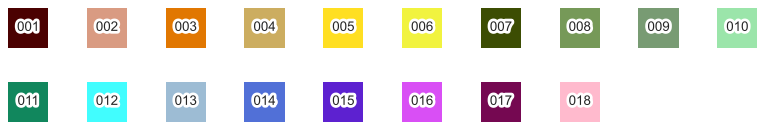

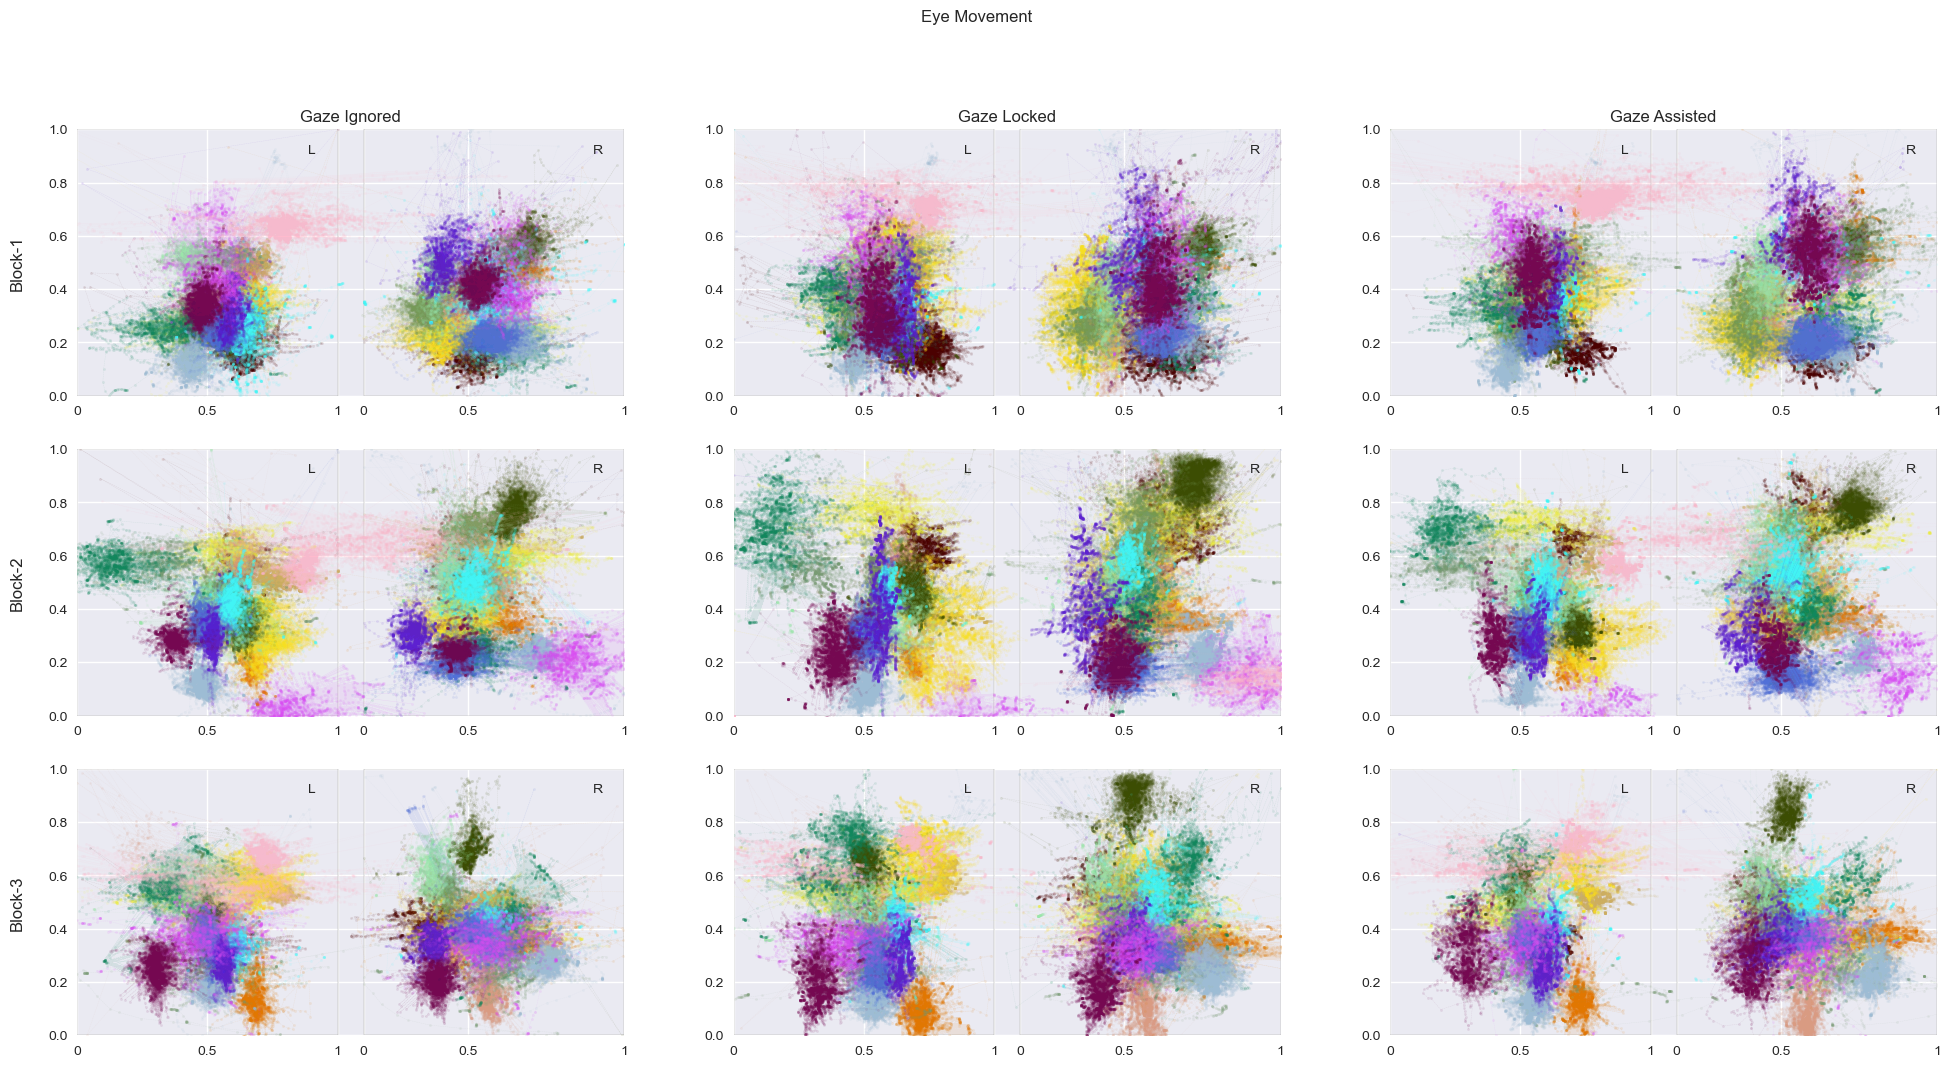

In [9]:
allSubj = subjects
# subjects = ['001', '004', '005']
# subjects = ['018']
plot_subject_colors()
plot_eye_movement(normalise_in_self=True)
subjects = allSubj

In [11]:
subjId = subjects[3]
datadict = load_subject(subjId)

ignoredDat = [[],[]]
lockedDat = [[],[]]
assistDat = [[],[]]

for blockId, block in enumerate(datadict.values()):
    # print(f"===== Block {blockId+1} =====")
    for trialId, trialData in enumerate(block.values()):        
        fConfig = trialData[-1]
        fEyeC = trialData[2]
        fEyeL = trialData[3]
        fEyeR = trialData[4]
        dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
        dfC = pd.read_csv(path.join(subjId, fEyeC), sep='\t')
        dfL = pd.read_csv(path.join(subjId, fEyeL), sep='\t')
        dfR = pd.read_csv(path.join(subjId, fEyeR), sep='\t')

        eyePosC = vec2coord(dfC.PosInSensor, [0,1])
        eyePosC = eyePosC[(eyePosC.x <= 1) & (eyePosC.x >= 0)]
        eyePosC = eyePosC[(eyePosC.y <= 1) & (eyePosC.y >= 0)]
        eyePosL = vec2coord(dfL.PosInSensor, [0,1])
        eyePosL = eyePosL[(eyePosL.x <= 1) & (eyePosL.x >= 0)]
        eyePosL = eyePosL[(eyePosL.y <= 1) & (eyePosL.y >= 0)]
        eyePosR = vec2coord(dfR.PosInSensor, [0,1])
        eyePosR = eyePosR[(eyePosR.x <= 1) & (eyePosR.x >= 0)]
        eyePosR = eyePosR[(eyePosR.y <= 1) & (eyePosR.y >= 0)]

        deltaC = eyePosC.diff()
        distC = np.sqrt(deltaC.x ** 2 + deltaC.y ** 2).sum()
        deltaL = eyePosL.diff()
        distL = np.sqrt(deltaL.x ** 2 + deltaL.y ** 2).sum()
        deltaR = eyePosR.diff()
        distR = np.sqrt(deltaR.x ** 2 + deltaR.y ** 2).sum()
        
        # print(f">> Trial-{trialId+1}: {condition}\n>>>> dL: {distL:.4f} ; dR: {distR:.4f} || Mean: {(distL+distR)/2:.4f}") 
        
        condition = dfCfg.GazeCondition[0]
        if 'ignored' in condition.lower():
            ignoredDat[0].append(blockId+1)
            ignoredDat[1].append((distL, distR, (distL+distR)/2))
        elif 'fixed' in condition.lower():
            lockedDat[0].append(blockId+1)
            lockedDat[1].append((distL, distR, (distL+distR)/2))
        elif 'assist' in condition.lower():
            assistDat[0].append(blockId+1)
            assistDat[1].append((distL, distR, (distL+distR)/2))

[]

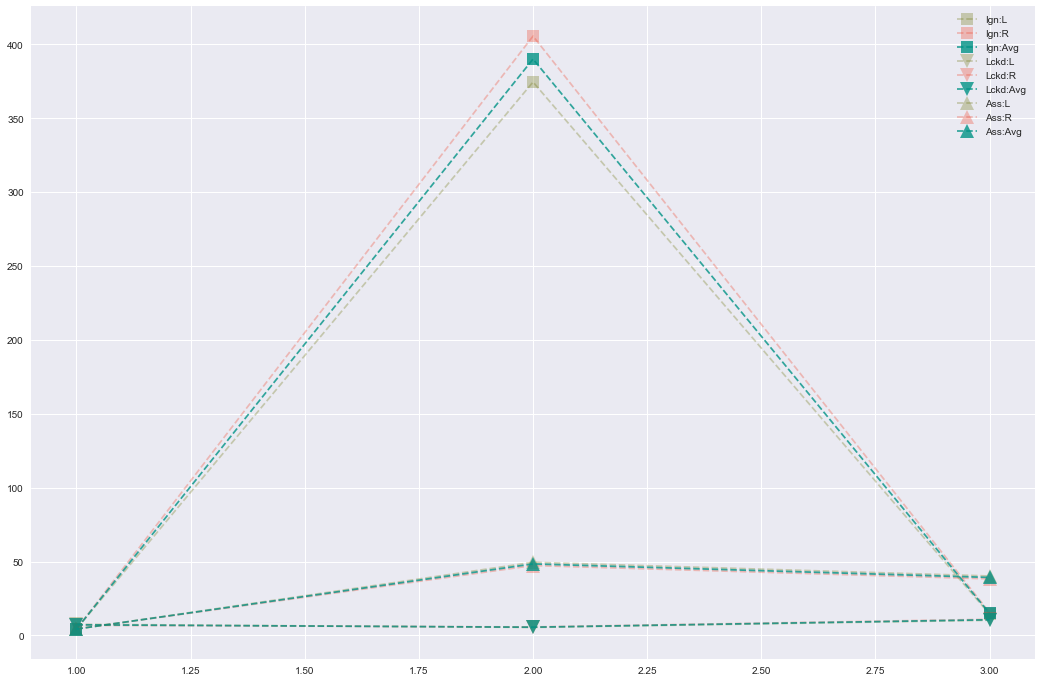

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18,12))

ax.plot(ignoredDat[0], [d[0] for d in ignoredDat[1]], 's--',
        markersize=12,
        label="Ign:L", color='xkcd:olive', alpha=.3)
ax.plot(ignoredDat[0], [d[1] for d in ignoredDat[1]], 's--',
        markersize=12,
        label="Ign:R", color='xkcd:tomato', alpha=.3)
ax.plot(ignoredDat[0], [d[2] for d in ignoredDat[1]], 's--',
        markersize=12,
        label="Ign:Avg", color='xkcd:teal', alpha=.8)

ax.plot(lockedDat[0], [d[0] for d in lockedDat[1]], 'v--',
        markersize=14,
        label="Lckd:L", color='xkcd:olive', alpha=.3)
ax.plot(lockedDat[0], [d[1] for d in lockedDat[1]], 'v--',
        markersize=14,
        label="Lckd:R", color='xkcd:tomato', alpha=.3)
ax.plot(lockedDat[0], [d[2] for d in lockedDat[1]], 'v--',
        markersize=14,
        label="Lckd:Avg", color='xkcd:teal', alpha=.8)

ax.plot(assistDat[0], [d[0] for d in assistDat[1]], '^--',
        markersize=14,
        label="Ass:L", color='xkcd:olive', alpha=.3)
ax.plot(assistDat[0], [d[1] for d in assistDat[1]], '^--',
        markersize=14,
        label="Ass:R", color='xkcd:tomato', alpha=.3)
ax.plot(assistDat[0], [d[2] for d in assistDat[1]], '^--',
        markersize=14,
        label="Ass:Avg", color='xkcd:teal', alpha=.8)

ax.legend()
plt.plot()

In [9]:
def get_filtered_eye_position(s:pd.Series):
    eyePos = vec2coord(s, [0,1])
    eyePos = eyePos[(eyePos.x <= 1) & (eyePos.x >= 0)]
    eyePos = eyePos[(eyePos.y <= 1) & (eyePos.y >= 0)]
    return eyePos

def get_eye_distance_travelled(s:pd.Series):
    eyePos = get_filtered_eye_position(s)
    delta = eyePos.diff()
    return np.sqrt(delta.x ** 2 + delta.y ** 2).sum()
    
def get_eye_average_dist(s_left:pd.Series, s_right:pd.Series):
    distL = get_eye_distance_travelled(s_left)
    distR = get_eye_distance_travelled(s_right)
    return (distL + distR) / 2

In [ ]:
data = np.zeros((3, 3, len(subjects)))

for idx, subjId in enumerate(subjects):
    datadict = load_subject(subjId)
    for blockIdx, blockId in enumerate(IDENTS):
        block = datadict[blockId]
        for trialId in IDENTS:
            trialData = block[trialId]
            fConfig = trialData[-1]
            fEyeL = trialData[3]
            fEyeR = trialData[4]
            dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
            dfL = pd.read_csv(path.join(subjId, fEyeL), sep='\t')
            dfR = pd.read_csv(path.join(subjId, fEyeR), sep='\t')
            
            condition = dfCfg.GazeCondition[0].lower()
            conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
            
            data[blockIdx, conIdx, idx] = get_eye_average_dist(dfL.PosInSensor, dfR.PosInSensor)

<AxesSubplot:xlabel='Block', ylabel='Distance'>

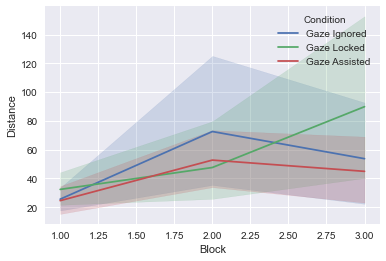

In [15]:
iterables = [[1,2,3],['Gaze Ignored', 'Gaze Locked', 'Gaze Assisted'], subjects]
index = pd.MultiIndex.from_product(iterables, names=['Block', "Condition", "Subject-ID"])
dat = pd.DataFrame(data=data.reshape(-1, 1), index=index, columns = ['Distance' ])

sns.lineplot(data=dat, x='Block', y='Distance', hue='Condition')

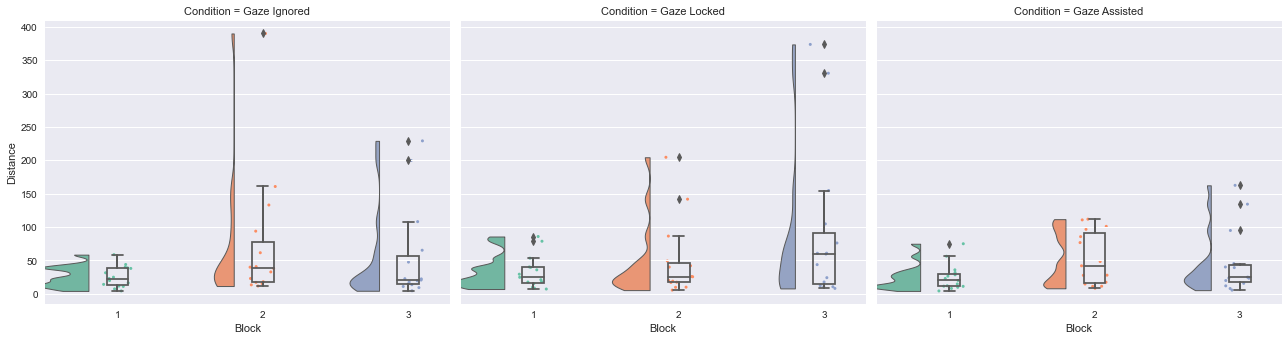

In [16]:
# pt.RainCloud(data=dat.reset_index(), x='Block', y='Distance', hue='Condition', orient='h')
# Rainclouds with FacetGrid
d = dat.reset_index()
g = sns.FacetGrid(d, col = "Condition", height = 6)
g = g.map_dataframe(pt.RainCloud, x = "Block", y = "Distance", data = d, orient = "v")

g.fig.subplots_adjust(top=0.75)
# g.fig.suptitle("Figure P13\n Using FacetGrid for More Complex Designs",  fontsize=26)

In [10]:
def prepare_single_eye(df:pd.DataFrame, is_combined=False) -> (str, pd.DataFrame):
    tmp = df.drop(columns=[c for c in df.columns if "Unnamed" in c])\
        .set_index(['TrackerTimeStamp', 'TimeStamp'])
    sensor_pos = vec2coord(tmp.PosInSensor, [0,1])
    gaze_pos = vec2coord(tmp.GazeOriginInEye, [0,1,2])
    gaze_dir = vec2coord(tmp.GazeDirectionNormInEye, [0,1,2])
    idx = tmp.EyeIndex.iloc[0]
    tmp = tmp.drop(columns=["PosInSensor", "GazeOriginInEye", "GazeDirectionNormInEye", 'EyeIndex'])
    eye = pd.concat((tmp, sensor_pos, gaze_pos, gaze_dir), axis=1, keys=["Other", "SensorPos", "GazeOrigin", "GazeDirection"])
    if is_combined:
        eye = eye.drop(columns=[('Other', 'Openness'), ('Other', 'PupilDiameter')]).drop(columns=["SensorPos"])
    return idx, eye

def merge_all_blocks_eyedata(subjId):
    block_eyes = []
    for block in IDENTS:
        trial_eyes = []
        for trial in IDENTS:
            fileL = f"{block}_{trial}SingleEyeDataRecordL.tsv"
            fileR = f"{block}_{trial}SingleEyeDataRecordR.tsv"
            fileC = f"{block}_{trial}SingleEyeDataRecordC.tsv"
            df = pd.read_csv(path.join(subjId, fileL), sep='\t')
            idxL, eyeL = prepare_single_eye(df)
            df = pd.read_csv(path.join(subjId, fileR), sep='\t')
            idxR, eyeR = prepare_single_eye(df)
            df = pd.read_csv(path.join(subjId, fileC), sep='\t')
            idxC, eyeC = prepare_single_eye(df, True)

            all_eyes = pd.concat([eyeL, eyeR, eyeC], axis=1, keys=[idxL, idxR, idxC])
            trial_eyes.append(all_eyes)

        block_eyes.append(pd.concat(trial_eyes, axis=0, keys=IDENTS))

    blockDf = pd.concat(block_eyes, axis=0, keys=IDENTS)
    names = list(blockDf.index.names)
    names[:2] = ['Block', 'Trial']
    blockDf.index.names = names
    
    return blockDf

In [ ]:
try:
    completeEyeData = pd.read_hdf('data.h5', key='complete_eye_data')
except (FileNotFoundError, KeyError) as e:
    print("Failed to load Eye Data from file data.h5; Recalculating")
    print(e)
    
    all_eye_data = []
    for subjId in subjects:
        all_eye_data.append(merge_all_blocks_eyedata(subjId))

    completeEyeData = pd.concat(all_eye_data, axis=1, keys=subjects)
    completeEyeData.to_hdf('data.h5', key='complete_eye_data', complevel=7)

In [15]:
data = np.zeros((3, 3, len(subjects), 2))

for idx, subjId in enumerate(subjects):
    datadict = load_subject(subjId)
    for blockIdx, blockId in enumerate(IDENTS):
        block = datadict[blockId]
        for trialId in IDENTS:
            trialData = block[trialId]
            fConfig = trialData[-1]
            fEngine = trialData[0]
            dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
            dfEngine = pd.read_csv(path.join(subjId, fEngine), sep='\t')
            
            condition = dfCfg.GazeCondition[0].lower()
            conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
            
            data[blockIdx, conIdx, idx, 0] = dfEngine.CollisionCount.iloc[-1]
            time_taken = dfEngine.TimeStamp.iloc[-1] - dfEngine.TimeStamp.iloc[0]
            time_taken /= 1e7 # c# ticks are 100 nano-seconds (100 1e-9 seconds -> 1e-7 seconds, so correct to seconds)
            data[blockIdx, conIdx, idx, 1] = time_taken

In [23]:
iterables = [[1,2,3],['Gaze Ignored', 'Gaze Locked', 'Gaze Assisted'], subjects]
index = pd.MultiIndex.from_product(iterables, names=['Block', "Condition", "Subject-ID"])
dat = pd.DataFrame(data=data.reshape(-1, 2), index=index, columns = ['CollisionCount', 'TimeTaken'])

# sns.lineplot(data=dat, x='Block', y='CollisionCount', hue='Condition')
# sns.lineplot(data=dat, x='Block', y='TimeTaken', hue='Condition')

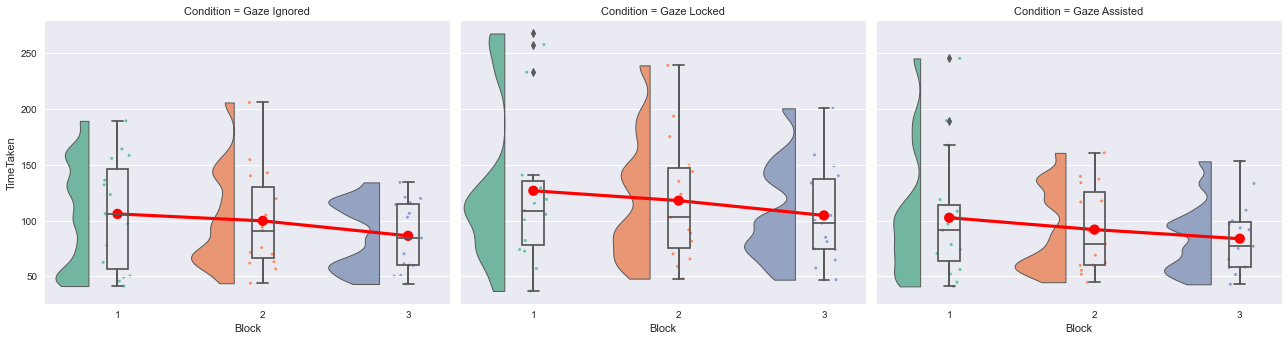

In [35]:
d = dat.reset_index()
g = sns.FacetGrid(d, col = "Condition", height = 6)
g = g.map_dataframe(pt.RainCloud, x = "Block", y = "TimeTaken", data = d, orient = "v", pointplot=True)
g.fig.subplots_adjust(top=0.75)
plt.show()

- per subject scaling
- scale each trial so that longest / mean / medial trial is 1 for each subject
- compare relative speed of condition across subjects

In [11]:
def project_vector(v, u):
    """Project vector v onto vector u"""
    return np.dot(v, u) / np.dot(u, u) * u

def point_in_rectangle(P:np.ndarray, A:np.ndarray, B:np.ndarray, C:np.ndarray, D:np.ndarray):
    """All points must be a 2x1 or 1x2 array. A -> D must be counter-clockwise corners of rectangle"""
    return 0 <= np.dot(P-A, B-A) <= np.dot(B-A, B-A) and 0 <= np.dot(P-A, D-A) <= np.dot(D-A, D-A)

def segment_to_point_distance_squared(P:np.ndarray, A:np.ndarray, B:np.ndarray):
    AP = P - A # vector from segment start to point
    AB = B - A # line segment
    D = A + project_vector(AP, AB) # project vector-to-point onto segment
    AD = D - A # vector from projected endpoint to segment start for 
    
    non_zero = np.where(AB != 0)[0]
    # check if projected point is on line segment
    if len(non_zero) > 0: # calculate scale of segment to projection
        k = (AD[non_zero] / AB[non_zero])[np.argmax(np.abs(AD[non_zero] / AB[non_zero]))]
    else:
        k = 0
    
    if k <= 0: # negative scale: is "behind" segment start
        return np.dot(AP , AP)
    elif k >= 1: # positive scale: is "beyond" segment
        return np.dot(P-B, P-B)
    else: # is on segment
        return np.dot(P-D, P-D)

def segment_intersects_circle(C:np.ndarray, r:float, A:np.ndarray, B:np.ndarray):
    dist = segment_to_point_distance_squared(C, A, B)
    # print(f"smallest distance from: {np.array2string(C, precision=3)} to" +
    #     f"Segment [{np.array2string(A)} -> {np.array2string(B)}]: {dist:.3f} :: R^2: {r*r:.3f}")
    return dist <= r*r

def circle_overlaps_rectangle(circle_center:np.ndarray, r:float, A:np.ndarray, B:np.ndarray, C:np.ndarray, D:np.ndarray):
    return  point_in_rectangle(circle_center, A, B, C, D) or \
            segment_intersects_circle(circle_center, r, A, B) or \
            segment_intersects_circle(circle_center, r, B, C) or \
            segment_intersects_circle(circle_center, r, C, D) or \
            segment_intersects_circle(circle_center, r, D, A)

In [12]:
def get_box_bb(box:Boxes, segmentEnd:float):
    if box == Boxes.SmallL:
        dY,dX,_ = smBox
        ll = [segmentEnd-dX, hwWidth-dY], None
    elif box == Boxes.SmallC:
        dY,dX,_ = smBox
        ll = [segmentEnd-dX, (hwWidth-dY) / 2], None
    elif box == Boxes.SmallR:
        dY,dX,_ = smBox
        ll = [segmentEnd-dX, 0], None
    elif box == Boxes.LargLC:
        dY,dX,_ = lgBox
        dY *= 2 # *2 because it's 2 boxes next to each other
        ll = [segmentEnd-dX, hwWidth-dY], None
    elif box == Boxes.LargCR:
        dY,dX,_ = lgBox
        dY *= 2 # *2 because it's 2 boxes next to each other
        ll = [segmentEnd-dX, 0], None
    elif box == Boxes.LargLR:
        dY,dX,_ = lgBox
        ll = [segmentEnd-dX, hwWidth - dY], [segmentEnd-dX, 0]
    else:
        return None, None

    ll = np.array(ll[0]), np.array(ll[1])
    lr = ll[0] + [dX, 0], (ll[1] + [dX, 0] if ll[1].shape != () else ll[1])
    ul = ll[0] + [0, dY], (ll[1] + [0, dY] if ll[1].shape != () else ll[1])
    ur = ul[0] + [dX, 0], (ul[1] + [dX, 0] if ul[1].shape != () else ll[1])

    return (ll[0], lr[0], ur[0], ul[0]), (ll[1], lr[1], ur[1], ul[1])

def collision_at_point(s:pd.Series) -> bool:
    x = s.x
    y = s.y
    zone = s.closestBoxZone
    box = s.closeBox
    rec1, rec2 = get_box_bb(box, (zone+1) * segmentLength)
    if rec1 is None:
        return False
    P = np.array([x, y])
    coll = circle_overlaps_rectangle(P, pRadius, rec1[0], rec1[1], rec1[2], rec1[3])
    if rec2[0].shape == ():
        return coll
    coll = coll or circle_overlaps_rectangle(P, pRadius, rec2[0], rec2[1], rec2[2], rec2[3])
    return coll
    

def distance_to_box_at_point(s:pd.Series) -> float:
    x = s.x
    y = s.y
    zone = s.closestBoxZone
    box = s.closeBox
    rec1, rec2 = get_box_bb(box, (zone+1) * segmentLength)
    if rec1 is None:
        return float('inf')
    P = np.array([x, y])
    dist = player_dist_to_box(P, rec1[0], rec1[1], rec1[2], rec1[3])
    if rec2[0].shape == ():
        return dist
    dist = min(dist, player_dist_to_box(P, rec2[0], rec2[1], rec2[2], rec2[3]))
    return dist


def player_dist_to_box(pos, A, B, C, D):
    if point_in_rectangle(pos, A, B, C, D):
        return 0
    return max(min(np.sqrt(segment_to_point_distance_squared(pos, A, B)),
                np.sqrt(segment_to_point_distance_squared(pos, B, C)),
                np.sqrt(segment_to_point_distance_squared(pos, C, D)),
                np.sqrt(segment_to_point_distance_squared(pos, D, A))) - pRadius, 0)

class Collisions(Enum):
    no = 0
    bump = 1
    strafe = 2
    crash = 5

def classify_collision(pos, r, A, B, C, D):
    # inside the box is a crash
    if point_in_rectangle(pos, A, B, C, D):
        return Collisions.crash
    # hit the "front" wall, so walked into it -> crash
    elif segment_to_point_distance_squared(pos, D, A) < r*r:
        return Collisions.crash
    # hit the side walls -> strafe as walking by || ToDo: Could classify as crash if dist < r/2?
    elif (segment_to_point_distance_squared(pos, A, B) < r*r) or \
        (segment_to_point_distance_squared(pos, C, D) < r*r):
        return Collisions.strafe
    # hit the "back" wall -> bump
    elif segment_to_point_distance_squared(pos, B, C) < r*r:
        return Collisions.bump
    else:
        return Collisions.no
    
def collision_type_at_point(s:pd.Series) -> float:
    x = s.x
    y = s.y
    zone = s.closestBoxZone
    box = s.closeBox
    rec1, rec2 = get_box_bb(box, (zone+1) * segmentLength)
    if rec1 is None:
        return Collisions.no
    P = np.array([x, y])
    coll = classify_collision(P, pRadius, rec1[0], rec1[1], rec1[2], rec1[3])
    if rec2[0].shape == ():
        return coll
    coll = max(coll, classify_collision(P, pRadius, rec2[0], rec2[1], rec2[2], rec2[3]))
    return coll

In [12]:
datadict = load_subject("004")
df = pd.read_csv(path.join('004', datadict[ID03][ID02][0]), sep='\t')
hwId = int(pd.read_csv(path.join('004', datadict[ID03][ID02][-1]), sep='\t').values[0,1][-1])-1
print(f"Hallway-{hwId+1}")

df = df.set_index('TimeStamp')
origin_pos = pos2path(df.XROriginPos, hwId)
head_pos = pos2path(df.XRHeadPos, hwId)



Hallway-2


In [24]:
head_pos['closestBoxZone'] = ((head_pos.x - segmentLength / 2) // 2).astype(int)
layout = [Boxes.NoBox, Boxes.NoBox] + hallway1 + [Boxes.NoBox]
head_pos['closeBox'] = head_pos.closestBoxZone.apply(lambda i: layout[i])
# head_pos[['closestBoxZone', 'closeBox']].apply(lambda r: r.iloc[0] * segmentLength, axis=1)#.apply(lambda b: get_box_bb(b))
# coll = head_pos.apply(lambda r: collision_at_point(r), axis=1)
dist = head_pos.apply(lambda r: distance_to_box_at_point(r), axis=1)
dist.replace(np.inf, dist[dist != np.inf].max(), inplace=True)
head_pos['distanceToBox'] = dist
head_pos['collision'] = dist == 0

11

In [13]:
def count_zones_with_collision(subjId):
    counts = np.zeros((3,3,2))
    dfs = np.zeros((3,3), dtype=object)
    hwIds = np.zeros((3,3), dtype=int)
    blocks = load_subject(subjId)
    for blockIdx, (block, trials) in enumerate(blocks.items()):
        for trialIdx, (trial, files) in enumerate(trials.items()):
            dfEng = load_csv(path.join(subjId, files[0]))
            dfCfg = load_csv(path.join(subjId, files[-1]))
            hwId = int(dfCfg.values[0,1][-1]) - 1
            condition = dfCfg.GazeCondition.iloc[0].lower()
            conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
            hallway = hallway1 if hwId == 0 else (hallway2 if hwId == 1 else hallway3)
            
            seconds = (dfEng.TimeStamp - dfEng.TimeStamp.iloc[0]) / 1e7
            time_taken = seconds.iloc[-1]
            
            dfEng.set_index('TimeStamp', inplace=True)
            head_pos = pos2path(dfEng.XRHeadPos, hwId)
            
            head_pos['closestBoxZone'] = ((head_pos.x - segmentLength / 2) // 2).astype(int)
            layout = [Boxes.NoBox, Boxes.NoBox] + hallway + [Boxes.NoBox]
            head_pos['closeBox'] = head_pos.closestBoxZone.apply(lambda i: layout[i])
            
            dist = head_pos.apply(lambda r: distance_to_box_at_point(r), axis=1)
            dist.replace(np.inf, dist[dist != np.inf].max(), inplace=True)
            head_pos['distanceToBox'] = dist
            head_pos['collision'] = dist == 0
            
            collC = head_pos.groupby('closestBoxZone')['collision'].max().sum()
            counts[blockIdx, conIdx] = [collC, time_taken]
            hwIds[blockIdx, conIdx] = hwId
            dfs[blockIdx, conIdx] = head_pos
            
    return counts, hwIds, dfs

In [124]:
counts, hwIds, dfs = count_zones_with_collision('004')

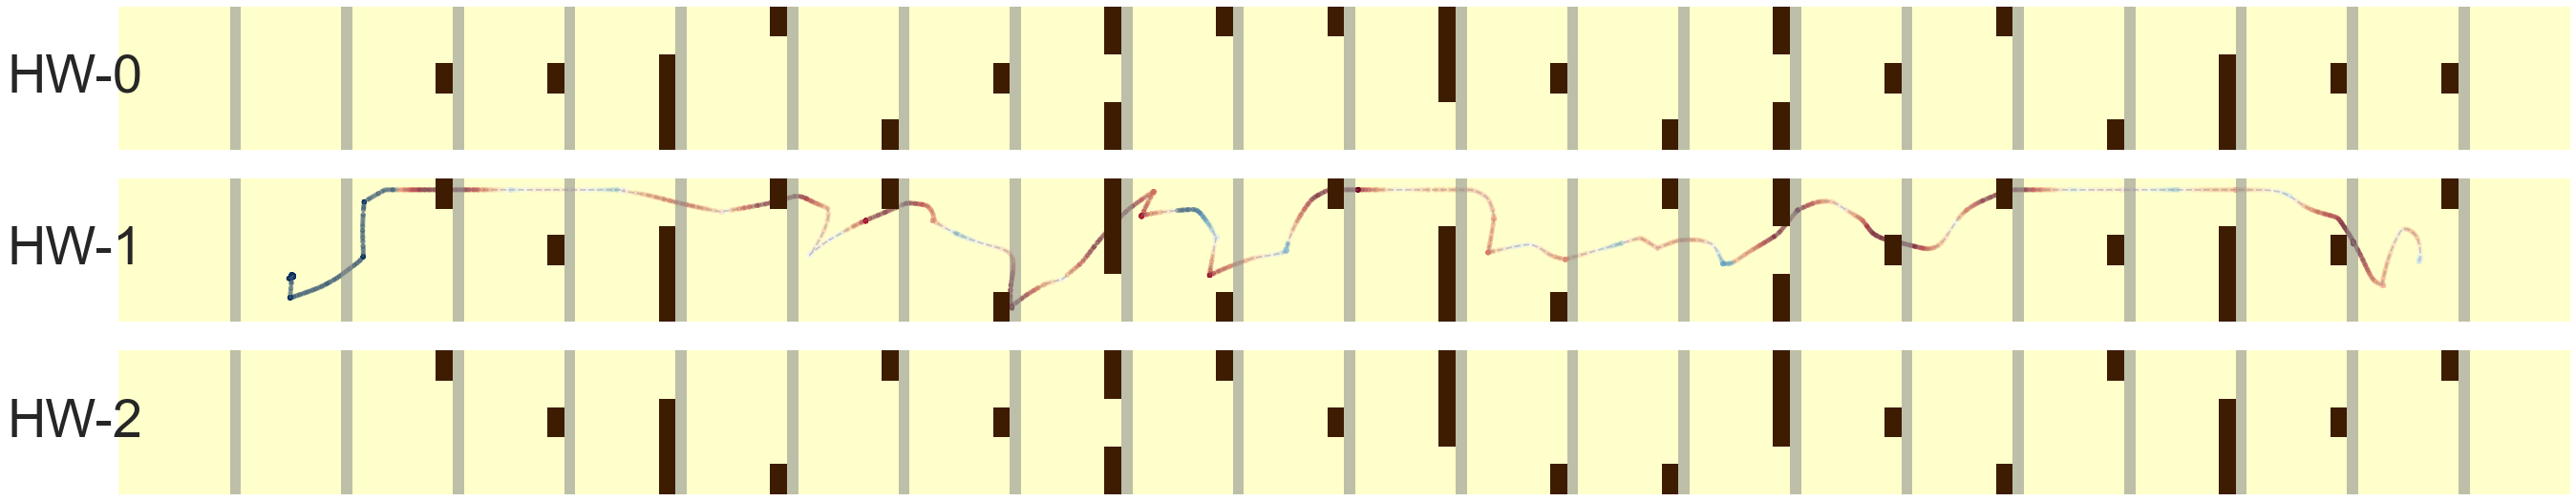

In [91]:
d = dfs[0, 2]
hwId = hwIds[0,2]
dist = d.distanceToBox

color_map = 'RdBu'#'nipy_spectral'
cmap = mpl.cm.get_cmap(color_map)
colors = cmap(dist.values / dist.max())

fig, axs = map_hallways()
scat, line = draw_path(d, axs, hwId, colors)

In [15]:
try:
    dfColl = pd.read_hdf('data.h5', key='collisions')
except:
    collisions = np.zeros((len(subjects),3,3,2))
    for idx, subjId in enumerate(subjects):
        counts, hwIds, dfs = count_zones_with_collision(subjId)
        collisions[idx] = counts
    
    collisions = np.swapaxes(collisions, 0, 1)
    dfColl = pd.DataFrame(collisions.reshape(-1, 2), pd.MultiIndex.from_product(([1,2,3], subjects, ["G.-Ign", "G.-Lck", "G.-Ass"]), names=["Block", "Subject", "Condition"]), ["Collisions", "TimeTaken"])
    dfColl = dfColl.reorder_levels([0,2,1])
    
    dfColl.to_hdf('data.h5', key='collisions', complevel=7)

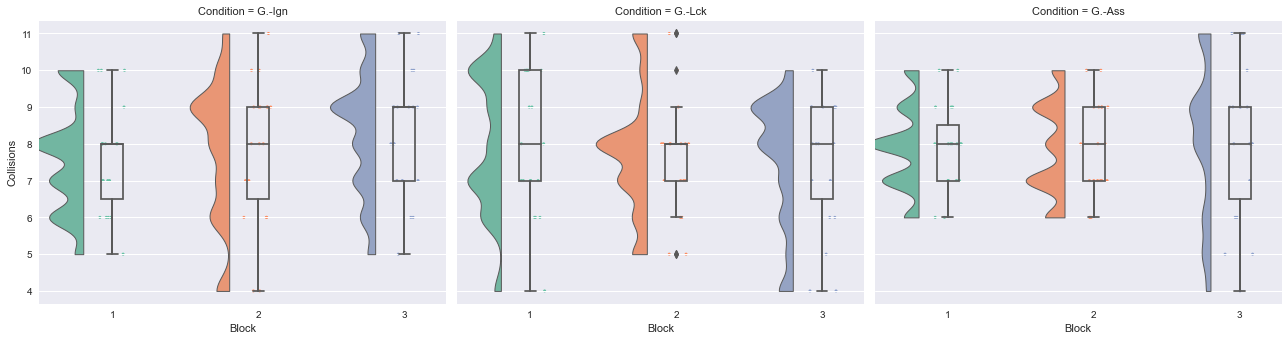

In [16]:
d = dfColl.reset_index()
g = sns.FacetGrid(d, col ="Condition", height = 6)
g = g.map_dataframe(pt.RainCloud, x = "Block", y = "Collisions", data = d, orient = "v", pointplot=False)
# g = g.map_dataframe(pt.RainCloud, x = "Block", y = "TimeTaken", data = d, orient = "v", pointplot=False)
g.fig.subplots_adjust(top=0.75)
plt.show()

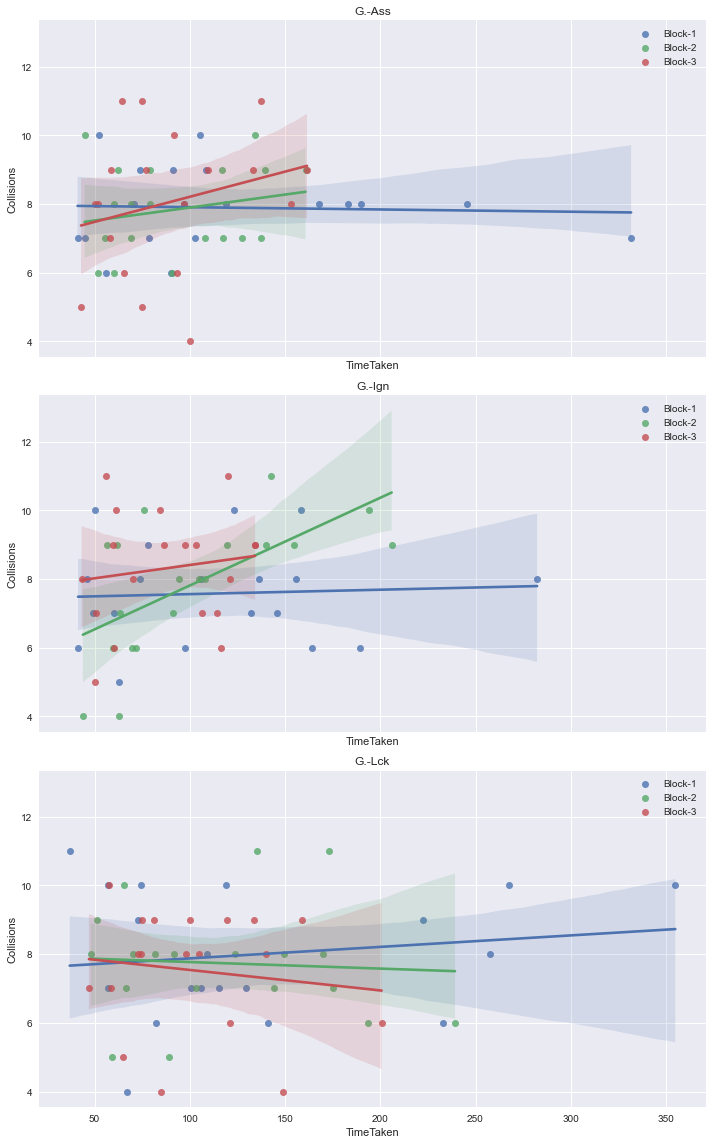

In [69]:
fig, axs = plt.subplots(3,1,figsize=(10,16), sharex=True, sharey=True)
for bId, block in enumerate([1,2,3]):
    ax = axs[bId]
    blockData = dfColl.loc[block]
    for cId, con in enumerate(dfColl.index.levels[1].values):
        ax = axs[cId]
        data = blockData.loc[con]
        sns.regplot(data=data, x="TimeTaken", y="Collisions", ax=ax, label=f"Block-{block}")
        ax.legend()
        
        if bId == 0:
            ax.set_title(con)
        
        
plt.tight_layout()

Gaze Ignored    --> G.-Ign. --> ❌
Gaze Locked     --> G.-Lck. --> 🔒
Gaze Assissted  --> G.-Ass. --> 👁️

In [63]:
import scipy.optimize as opt

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

# Create x and y indices
x = np.linspace(0, 400, 401)
y = np.linspace(0, 20, 21)
x, y = np.meshgrid(x, y)

# #create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 0, 10)

# # plot twoD_Gaussian data generated above
# plt.figure()
# plt.imshow(data.reshape(201, 201))
# plt.colorbar()

# # add some noise to the data and try to fit the data generated beforehand
# initial_guess = (3,100,100,20,40,0,10)

# data_noisy = data + 0.2*np.random.normal(size=data.shape)

# popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

# data_fitted = twoD_Gaussian((x, y), *popt)

# fig, ax = plt.subplots(1, 1)
# ax.hold(True)
# ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
#     extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
# plt.show()

(8421,)

(<matplotlib.collections.PathCollection at 0x2798eacb0a0>,
 [<matplotlib.lines.Line2D at 0x2798eaca320>])

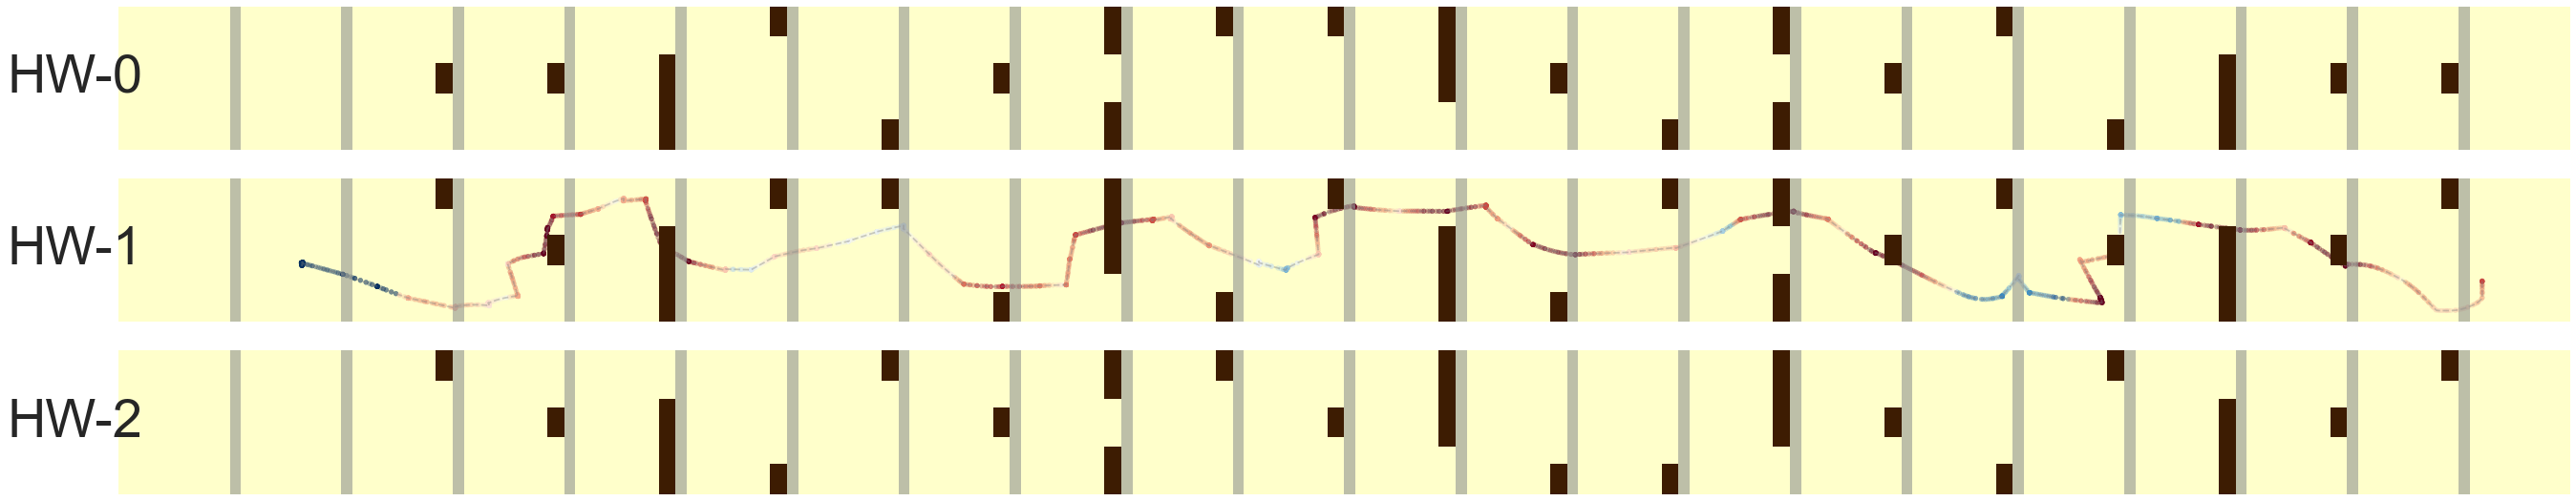

In [318]:
color_map = 'RdBu'#'nipy_spectral'
cmap = mpl.cm.get_cmap(color_map)
colors = cmap(dist.values / dist.max())

fig, axs = map_hallways()
# draw_path(df.XROriginPos, axs, hwId, 'xkcd:coral')
draw_path(df.XRHeadPos, axs, hwId, colors)

In [104]:
# head_pos.join(coll.rename("Collision"))
prev = pd.read_csv(path.join('004', datadict[ID02][ID01][0]), sep='\t')
prev.set_index('TimeStamp', inplace=True)
df = pd.read_csv(path.join('004', datadict[ID02][ID02][0]), sep='\t')
df["seconds"] = (df.TimeStamp - df.TimeStamp.iloc[0]) / 1e7
df.set_index("TimeStamp", inplace=True)
s = df[['XRHeadPos', 'seconds']]
s = s.join(vec2coord(s.XRHeadPos, [0,1,2]))
wrong = df[df.seconds < 2]
# wrong = wrong[s.z > 5]
# wrong
# wrong
# prev.merge(wrong, how='outer')
# (s.z > 5).index
prev.merge(wrong.loc[s[(s.seconds < 2) & (s.z > 5)].index], how='outer')

XROriginPos                0
XROriginRot                0
XROriginInBox              0
XROriginInCheckpoint       0
XRHeadPos                  0
XRHeadRot                  0
HandLPos                   0
HandLRot                   0
HandLInBox                 0
HandLInWall                0
HandRPos                   0
HandRRot                   0
HandRInBox                 0
HandRInWall                0
CollisionCount             0
CheckpointCount            0
FrameCount                 0
Unnamed: 18             3325
seconds                 3295
dtype: int64

In [31]:
import struct
TrialConfigStruct = struct.Struct("sssfc")

def load_csv(path:str) -> pd.DataFrame:
    df = pd.read_csv(path, sep='\t', usecols=lambda c: not c.startswith('Unnamed:'))
    return df

def subject2dataframe(subjId:str) -> pd.DataFrame:
    blocks = load_subject(subjId)
    block_dfs = []
    for blockIdx, (block, trials) in enumerate(blocks.items()):
        trial_dfs = []
        keys = []
        for trialIdx, (trial, files) in enumerate(trials.items()):
            # 0 -> Engine
            dfEngine = load_csv(path.join(subjId, files[0]))
            # 1 -> Tracker Data
            dfTracker = load_csv(path.join(subjId, files[1]))
            # 2 -> Eye Data Combined
            dfEyeC = load_csv(path.join(subjId, files[2]))
            # 3 -> Eye Data Left
            dfEyeL = load_csv(path.join(subjId, files[3]))
            # 4 -> Eye Data Right
            dfEyeR = load_csv(path.join(subjId, files[4]))
            # 5 -> Config
            dfConfig = load_csv(path.join(subjId, files[5]))

            # create combined 2-level eye data
            eyeData = pd.concat([dfTracker.set_index("TimeStamp"), 
                                dfEyeC.set_index("TimeStamp"), 
                                dfEyeL.set_index("TimeStamp"), 
                                dfEyeR.set_index("TimeStamp")],
                                keys=["TrackerData", "CombinedEyeData", "LeftEyeData", "RightEyeData"], axis=1)
            # engine data as 2-level for join
            dfEngine = dfEngine.set_index("TimeStamp")
            dfEngine.columns = pd.MultiIndex.from_product([["EngineData"], dfEngine.columns])
            # config data as 2-level for join
            dfConfig.columns = pd.MultiIndex.from_product([["ConfigData"], dfConfig.columns])

            # combine all into one
            dfTrial = dfConfig.join(dfEngine.join(eyeData, how='outer'), how='outer')
            trial_dfs.append(dfTrial)

        block_dfs.append(pd.concat(trial_dfs, keys=[1,2,3], axis=0, names=['Trial', 'TimeStamp']))
    
    return pd.concat(block_dfs, keys=[1,2,3], axis=0, names=['Block', 'Trial', 'TimeStamp'])

def allsubjects2dataframe(subjects) -> pd.DataFrame:
    dfs = []
    for subjId in subjects:
        dfs.append(subject2dataframe(subjId))

    return pd.concat(dfs, keys=subjects, axis=0, names=['Subject', 'Block', 'Trial', 'TimeStamp'])


dfSub = allsubjects2dataframe(subjects)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [263]:
dfSub

ConfigData                    \
                                       GazeCondition   Hallway Glasses   
Subject Block Trial TimeStamp                                            
001     1     1     0                    GazeIgnored  Hallway2    None   
                    637933112670323951           NaN       NaN     NaN   
                    637933112670380485           NaN       NaN     NaN   
                    637933112670500486           NaN       NaN     NaN   
                    637933112670650501           NaN       NaN     NaN   
...                                              ...       ...     ...   
015     3     3     637937632186596582           NaN       NaN     NaN   
                    637937632186706576           NaN       NaN     NaN   
                    637937632186736570           NaN       NaN     NaN   
                    637937632186896571           NaN       NaN     NaN   
                    637937632186926576           NaN       NaN     NaN   

                                                                         \
                                       GazeRaySensitivity DataDelimiter   
Subject Block Trial TimeStamp                                             
001     1     1     0                                 1.0                 
                    637933112670323951                NaN           NaN   
                    637933112670380485                NaN           NaN   
                    637933112670500486                NaN           NaN   
                    637933112670650501                NaN           NaN   
...                                                   ...           ...   
015     3     3     637937632186596582                NaN           NaN   
                    637937632186706576                NaN           NaN   
                    637937632186736570                NaN           NaN   
                    637937632186896571                NaN           NaN   
                    637937632186926576                NaN           NaN   

                                                          EngineData  \
                                                         XROriginPos   
Subject Block Trial TimeStamp                                          
001     1     1     0                                            NaN   
                    637933112670323951   (4.00000, 0.00000, 0.00000)   
                    637933112670380485                           NaN   
                    637933112670500486   (4.00000, 0.00000, 0.00000)   
                    637933112670650501   (4.00000, 0.00000, 0.00000)   
...                                                              ...   
015     3     3     637937632186596582  (3.41172, 0.00000, 39.16171)   
                    637937632186706576  (3.41172, 0.00000, 39.16171)   
                    637937632186736570                           NaN   
                    637937632186896571                           NaN   
                    637937632186926576  (3.41172, 0.00000, 39.16171)   

                                                                              \
                                                                 XROriginRot   
Subject Block Trial TimeStamp                                                  
001     1     1     0                                                    NaN   
                    637933112670323951  (0.00000, 0.00000, 0.00000, 1.00000)   
                    637933112670380485                                   NaN   
                    637933112670500486  (0.00000, 0.00000, 0.00000, 1.00000)   
                    637933112670650501  (0.00000, 0.00000, 0.00000, 1.00000)   
...                                                                      ...   
015     3     3     637937632186596582  (0.00000, 0.00000, 0.00000, 1.00000)   
                    637937632186706576  (0.00000, 0.00000, 0.00000, 1.00000)   
                    637937632186736570                           

In [116]:
subjects = ['001', '004', '005']
data = np.zeros((3, 3, len(subjects), 2))

for idx, subjId in tqdm(enumerate(subjects), desc="Processing Subjects", position=0, leave=True):
    datadict = load_subject(subjId)
    for blockIdx, blockId in enumerate(IDENTS):
        block = datadict[blockId]
        for trialId in IDENTS:
            trialData = block[trialId]
            fConfig = trialData[-1]
            fEngine = trialData[0]
            dfCfg = pd.read_csv(path.join(subjId, fConfig), sep='\t')
            dfEngine = pd.read_csv(path.join(subjId, fEngine), sep='\t')
            
            condition = dfCfg.GazeCondition[0].lower()
            conIdx = 0 if 'ignored' in condition else 1 if 'fixed' in condition else 2
            hwId = int(dfCfg.Hallway[0][-1]) - 1
            
            head_pos = pos2path(dfEngine.XRHeadPos, hwId)
            head_pos['closestBoxZone'] = ((head_pos.x - segmentLength / 2) // 2).astype(int)
            layout = [Boxes.NoBox, Boxes.NoBox] + hallway1 + [Boxes.NoBox]
            head_pos['closeBox'] = head_pos.closestBoxZone.apply(lambda i: layout[i])
            coll = head_pos.apply(lambda r: collision_at_point(r), axis=1)
            
            data[blockIdx, conIdx, idx, 0] = coll.diff().sum()
            time_taken = dfEngine.TimeStamp.iloc[-1] - dfEngine.TimeStamp.iloc[0]
            time_taken /= 1e7 # c# ticks are 100 nano-seconds (100 1e-9 seconds -> 1e-7 seconds, so correct to seconds)
            data[blockIdx, conIdx, idx, 1] = time_taken

Processing Subjects: 0it [00:00, ?it/s]


KeyboardInterrupt



In [115]:
iterables = [[1,2,3],['Gaze Ignored', 'Gaze Locked', 'Gaze Assisted'], subjects]
index = pd.MultiIndex.from_product(iterables, names=['Block', "Condition", "Subject-ID"])
dat = pd.DataFrame(data=data.reshape(-1, 2), index=index, columns = ['CollisionCount', 'TimeTaken'])

# sns.lineplot(data=dat, x='Block', y='CollisionCount', hue='Condition')
# sns.lineplot(data=dat, x='Block', y='TimeTaken', hue='Condition')

NameError: name 'data' is not defined

,,,Collisions,TimeTaken
Condition,Block,Subject,,
G.-Ign,1,001,10.0,123.377676
G.-Lck,1,001,10.0,267.795913
G.-Ass,1,001,9.0,91.381563
G.-Ign,1,004,8.0,45.736628
G.-Lck,1,004,10.0,74.083874
G.-Ass,1,004,7.0,44.785433
G.-Ign,1,005,7.0,132.091667
G.-Lck,1,005,8.0,257.823629
G.-Ass,1,005,8.0,189.744560


C:\Users\nipsh\AppData\Local\Temp\ipykernel_36596\2607878078.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = dat.loc[block, condition]
C:\Users\nipsh\AppData\Local\Temp\ipykernel_36596\2607878078.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = dat.loc[block, condition]
C:\Users\nipsh\AppData\Local\Temp\ipykernel_36596\2607878078.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = dat.loc[block, condition]
C:\Users\nipsh\AppData\Local\Temp\ipykernel_36596\2607878078.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = dat.loc[block, condition]
C:\Users\nipsh\AppData\Local\Temp\ipykernel_36596\2607878078.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = dat.loc[block, condition]
C:\Users\nipsh\AppData\Local\Temp\ipykernel_36596\2607878078.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.


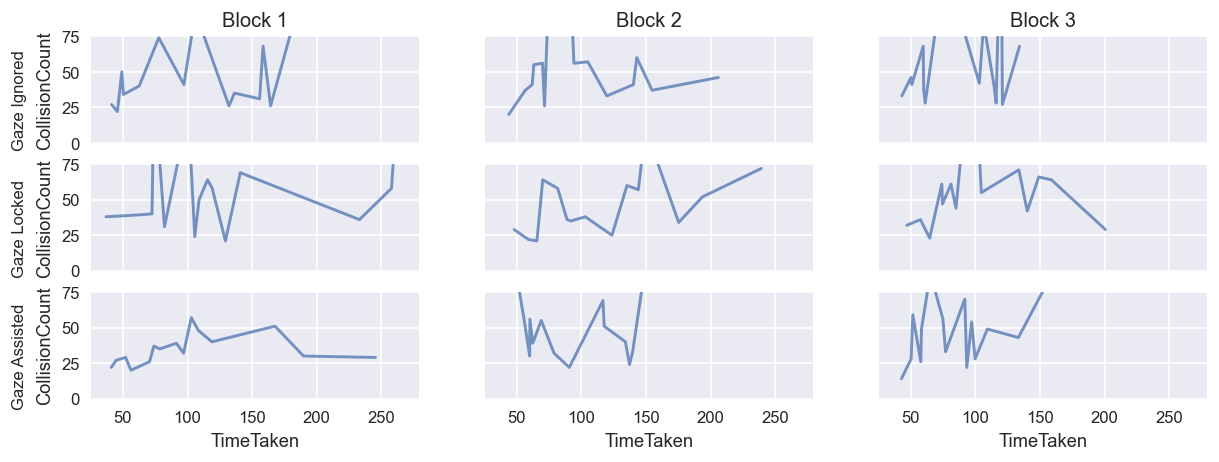

In [193]:
fig, axs = plt.subplots(3, 3, figsize=(12,4), dpi=120, sharey=True, sharex=True)

for blockIdx, block in enumerate([1,2,3]):
    for condIdx, condition in enumerate(['Gaze Ignored', 'Gaze Locked', 'Gaze Assisted']):
        ax = axs[condIdx, blockIdx]

        if condIdx == 0:
            ax.set_title(f"Block {block}")
        if blockIdx == 0:
            ax.text(-30, 30, condition, rotation=90, va="center", ha="center")
        ax.set_ylim((0, 75))

        d = dat.loc[block, condition]
        sns.lineplot(data=d, x="TimeTaken", y="CollisionCount", ax=ax, alpha=.75)